In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

--2020-06-29 14:30:45--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 540189 (528K) [image/jpeg]
Saving to: ‘1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg’

1200px-Van_Gogh_-_S 100%[===================>] 527.53K  --.-KB/s    in 0.06s   

2020-06-29 14:30:45 (8.05 MB/s) - ‘1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg’ saved [540189/540189]



In [ ]:
!wget https://millionstatusov.ru/pic/statpic/all8/5e206f1887bbc.jpg

--2020-06-29 13:03:20--  https://millionstatusov.ru/pic/statpic/all8/5e206f1887bbc.jpg
Resolving millionstatusov.ru (millionstatusov.ru)... 46.36.221.210
Connecting to millionstatusov.ru (millionstatusov.ru)|46.36.221.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48860 (48K) [image/jpeg]
Saving to: ‘5e206f1887bbc.jpg’

5e206f1887bbc.jpg   100%[===================>]  47.71K  --.-KB/s    in 0.03s   

2020-06-29 13:03:20 (1.37 MB/s) - ‘5e206f1887bbc.jpg’ saved [48860/48860]



Импорт модулей

In [ ]:
import torch
import numpy as np
import PIL
import os
import sys

from skimage import io, transform

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, utils, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import itertools

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from IPython.display import clear_output

In [ ]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
DATA_MODES = ['test', 'train']
# работаем на видеокарте
DEVICE = torch.device("cuda")

Преобразование картинок

In [ ]:
class ModelDataset(Dataset):

    def __init__(self, path):
        super().__init__()
        self.image = list(Path(path).rglob('*.jpg'))
        self.augmentation =  transforms.Compose([
                                  transforms.Resize((256, 256)),
                                  transforms.ToTensor()
                            ])

    
    def load(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        A = self.load(self.image[index])
        A = np.array(np.array(A) / 255, dtype='float32')
        A = self.augmentation(Image.fromarray((A*255).astype('uint8')))
        return A

    def __len__(self):
        return 1

    def create_batch(self, im):
        im = im[:3, :, :].unsqueeze(0)
        return im

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.title(title)
    plt_ax.grid(False)

In [ ]:
images = ModelDataset('/content/')

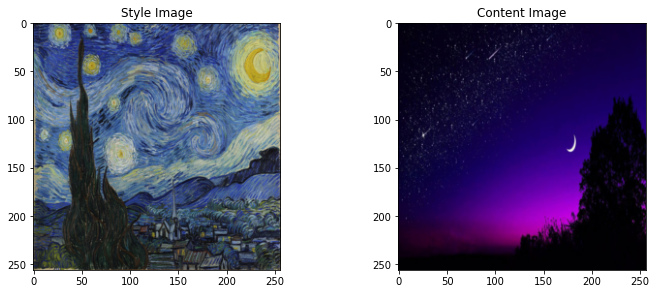

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
imshow(images[1], title='Style Image')

plt.subplot(2, 2, 2)
imshow(images[0], title='Content Image')


plt.show()

In [ ]:
content = images.create_batch(images[0]).to(DEVICE)

style = images.create_batch(images[1]).to(DEVICE)

Лоссы

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()

        self.target = target.detach()

    def forward(self, input):
        self.loss = torch.nn.functional.mse_loss(input, self.target)
        return input

In [ ]:
class GramMatrix():

    def __init__(self, input):
        self.input = input
        self.batch_size, self.number_of_feature_maps, self.height, self.width = input.size()

    def calculate(self):
        features = self.input.view(self.batch_size * self.number_of_feature_maps, self.height * self.width)

        G = torch.mm(features, features.t())  
        # Нормализуем величины
        return G.div(self.batch_size * self.number_of_feature_maps * self.height * self.width)  

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        gram = GramMatrix(target_feature.detach())
        self.target = gram.calculate()

    def forward(self, input):
        G = GramMatrix(input)
        target_G = G.calculate()
        self.loss = torch.nn.functional.mse_loss(target_G, self.target)
        return input


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Тренировка


In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(DEVICE)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


In [ ]:
def train(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, optimizer, mode='train', num_steps=300,
                       style_weight=1e3, content_weight=1e-2):
    """Run the style transfer."""

    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0 and mode=='train':
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img


In [ ]:
model = models.vgg19(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
model = nn.DataParallel(model)

In [ ]:
torch.save(model.module.state_dict(), './content.pth')

In [ ]:
print(model)

DataParallel(
  (module): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1

In [ ]:
model = models.vgg19(pretrained=False)

In [ ]:
model = models.vgg19(pretrained=True).features.to(DEVICE).eval()

# input = torch.randn(content.data.size(), device=DEVICE)
input = content.clone()

optim = torch.optim.LBFGS([input.requires_grad_()])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
model = models.vgg19(pretrained=True).features.to(DEVICE).eval()

input = content.clone()

optim = torch.optim.LBFGS([input.requires_grad_()])

In [ ]:
target_image = train(model, cnn_normalization_mean, cnn_normalization_std, content, style, input, optim)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 0.160028 Content Loss: 0.190514

run [100]:
Style Loss : 0.030778 Content Loss: 0.164123

run [150]:
Style Loss : 0.014713 Content Loss: 0.147236

run [200]:
Style Loss : 0.011961 Content Loss: 0.140217

run [250]:
Style Loss : 0.010971 Content Loss: 0.136791

run [300]:
Style Loss : 0.010478 Content Loss: 0.134697



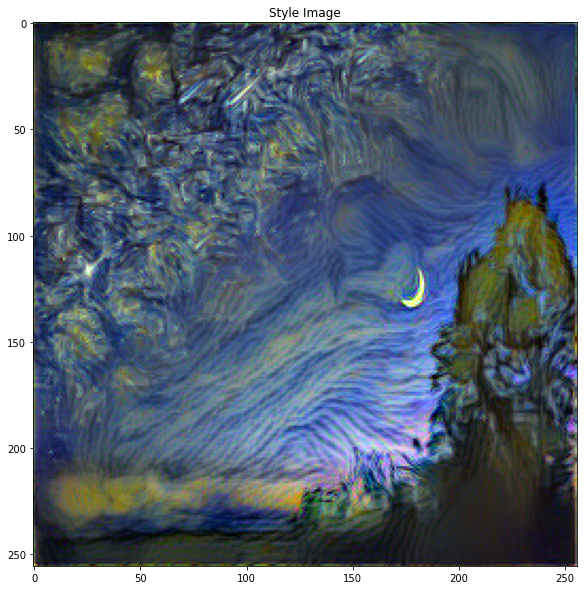

In [ ]:
plt.figure(figsize=(12, 10))
imshow(target_image[0].detach().cpu(), title='Style Image')

plt.show()

In [ ]:
torch.save(model.state_dict(), f"/content/weights/model.pth")

In [ ]:
im = ModelDataset('/content/test/')

content2 = images.create_batch(images[0]).to(DEVICE)

In [ ]:
def test(content_img, model_A, style_img):
    plt.figure(figsize=(24, 6))

    plt.title('Fake photo')
    plt.axis("off")
    model, _, _  = get_style_model_and_losses(model_A, cnn_normalization_mean, cnn_normalization_std, style_img, content_img)
    content_img.data.clamp_(0, 1)
    model(content_img)
    imshow(content_img[0].detach().cpu())

    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


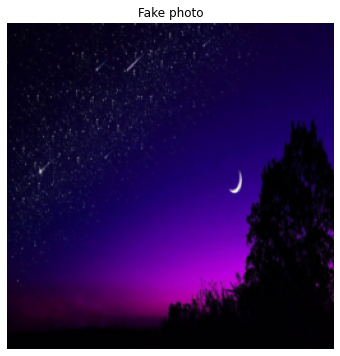

In [ ]:
test(content2, model, style)